# Climate Chart

### Problem
Given a Geohash prefix, create a climate chart for the region. This includes high, low, and average temperatures, as well as monthly average rainfall. 

Earn up to 1 point of extra credit for enhancing/improving this chart (or porting it to a more feature-rich visualization library)

## Setup the environment
Importing required types and the schema

In [12]:
from pyspark.sql.types import StructType, StructField, FloatType, LongType, StringType
import pandas as pd

In [2]:
hdfs_port = "hdfs://orion11:26990"
# data_path = "/nam_s/nam_201501_s*"
data_path = "/nam_s/*"
# data_path = "/sample/nam_tiny*"

In [3]:
feats = []
f = open('../features.txt')
for line_num, line in enumerate(f):
    if line_num == 0:
        # Timestamp
        feats.append(StructField(line.strip(), LongType(), True))
    elif line_num == 1:
        # Geohash
        feats.append(StructField(line.strip(), StringType(), True))
    else:
        # Other features
        feats.append(StructField(line.strip(), FloatType(), True))
    
schema = StructType(feats)

## Custom Geohash

This is the geohash prefix value.

West Santa Cruz, CA can be hashed as: 9q94.

In [122]:
area_name = "West Santa Cruz, CA"
hash_regex = "9q94"

## Query and Filterting

This query takes filters for the hash_prefix and then finds temperature (avg, min and max) and rain (avg) per month.


In [123]:
df = spark.read.format('csv').option('sep', '\t').schema(schema).load(f'{hdfs_port}{data_path}')

df.createOrReplaceTempView("nam_small")

query_str = f'''
SELECT AVG(temperature_surface) AS tmp_avg,
    MIN(temperature_surface) AS tmp_min,
    MAX(temperature_surface) AS tmp_max,
    AVG(categorical_rain_yes1_no0_surface) AS rain_avg,
    FROM_UNIXTIME(Timestamp/1000, 'YYYY-MM') AS year_month
FROM nam_small
WHERE Geohash LIKE "{hash_regex}%"
GROUP BY year_month
ORDER BY year_month
'''

print(query_str)


SELECT AVG(temperature_surface) AS tmp_avg,
    MIN(temperature_surface) AS tmp_min,
    MAX(temperature_surface) AS tmp_max,
    AVG(categorical_rain_yes1_no0_surface) AS rain_avg,
    FROM_UNIXTIME(Timestamp/1000, 'YYYY-MM') AS year_month
FROM nam_small
WHERE Geohash LIKE "9q94%"
GROUP BY year_month
ORDER BY year_month



### Run the SQL Query

In [124]:
%%time

climate = spark.sql(query_str)
p_df = climate.toPandas()

CPU times: user 19.9 ms, sys: 6.16 ms, total: 26.1 ms
Wall time: 3min 36s


## Results

In [125]:
p_mod = p_df[['year_month', 'tmp_max', 'tmp_min', 'rain_avg', 'tmp_avg']]
p_mod = p_mod[p_mod.year_month.str.contains('2015')]
p_mod.year_month = p_mod.year_month.str.slice(5, 8)
p_mod.sort_values(by=['year_month'])
p_mod.year_month = pd.to_numeric(p_mod.year_month, errors='coerce')
print(p_mod)

    year_month     tmp_max     tmp_min  rain_avg     tmp_avg
0            1  293.147491  277.343628  0.000000  286.681041
1            2  295.352142  276.090881  0.097222  287.280877
2            3  299.342957  278.923889  0.007407  287.444557
3            4  299.979492  278.704407  0.088235  285.626077
4            5  299.283691  280.529541  0.044444  286.456124
5            6  307.286865  282.197021  0.013986  289.131597
6            7  306.211182  285.962646  0.067669  291.129277
7            8  309.348877  286.284180  0.044444  292.214961
8            9  309.832031  285.267334  0.019481  291.953125
9           10  303.532715  284.335602  0.014815  291.247297
10          11  292.403931  274.230560  0.030534  286.411788
11          12  290.827484  275.092590  0.183673  286.720816


In [142]:
# <month-num>  <high-temp>  <low-temp>  <avg-precip>  <avg-temp>
data = p_mod.values
data
print(data.shape)

(12, 5)


### Graphing functions

Copied and pasted from your code w/ slight modifications to the name and data import

In [143]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib import rc

def c2f(t):
    return (t*9/5.0)+32

def k2c(t):
    return t-273.15

def k2f(t):
    return (t*9/5.0)-459.67

def disable_spines(ax):
    for s in ax.spines:
        ax.spines[s].set_visible(False)

def graph_climate(data):
    rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

    use_c = True
    converter = k2f
    if use_c:
        converter = k2c
    data = np.copy(data)
    data[:, 0] = data[:, 0] - 1
    data[:, 1] = converter(data[:, 1])
    data[:, 2] = converter(data[:, 2])
    if use_c == False:
        data[:, 3] = data[:, 3] * 0.0393701
    data[:, 4] = converter(data[:, 4])

    plt.ion()
    plt.clf()
    fig = plt.figure(1)
    fig.subplots_adjust(hspace=.20)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1.75, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharex=ax0)
    plt.setp(ax0.get_xticklabels(), visible=False) # disable upper axis label

    ax0.patch.set_facecolor('None')
    ax1.patch.set_facecolor('None')

    plt.suptitle('Climate Overview: ' + area_name, fontsize=14)

    if k2c(data[:, 1]).min() < 5:
        y = 0
        if not use_c:
            y = c2f(0)
        ax0.plot([0, data[:, 0].max() + 1], [y, y], zorder=-1, color='#888888',
                alpha=.75, dashes=(8, 2))

    rects0 = ax0.bar(.35 + data[:, 0], data[:, 2] - data[:, 1], bottom=data[:, 1],
            width=.6, color='#df3c3c', edgecolor='#731515')

    rects1 = ax1.bar(.35 + data[:, 0], data[:, 3], color='#1b7edb', width=.6,
            edgecolor='#1d4871')

    plt.xticks(np.arange(0,12) + .4, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        rotation=30)

    disable_spines(ax0)
    disable_spines(ax1)
    ax0.spines['left'].set_visible(True)
    ax1.spines['left'].set_visible(True)

    for tic in ax0.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False

    for tic in ax0.yaxis.get_major_ticks():
        tic.tick2On = False

    for tic in ax1.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False

    for tic in ax1.yaxis.get_major_ticks():
        tic.tick2On = False

    for rect in rects1:
        height = rect.get_height()
        ax1.text(rect.get_x() + rect.get_width()/2., 1.08*height,
            '%.1f' % (height), ha='center', va='bottom', color='#1d4871')

    for r, rect in enumerate(rects0):
        height = rect.get_height()
        ax0.text(rect.get_x() + rect.get_width()/2., rect.get_y() + 1.08*height,
            '%d' % int(height + rect.get_y()), ha='center', va='bottom',
            color='#731515')
        ax0.text(rect.get_x() + rect.get_width()/2., rect.get_y() - 2,
            '%d' % int(rect.get_y()), ha='center', va='top', color='#731515')
        ax0.plot([rect.get_x() + .05, rect.get_x() + rect.get_width() - .05],
                [data[r, 4], data[r, 4]], color='#731515')

    if use_c:
        ax0.set_ylabel('Temperature (C)')
        ax1.set_ylabel('Precipitation (cm)')
    else:
        ax0.set_ylabel('Temperature (F)')
        ax1.set_ylabel('Precipitation (in)')

    # plt.savefig(area_name + '-climate.pdf', bbox_inches='tight')
    plt.show()

## Plot the Data

This is a plot of the data from the west side of Santa Cruz, CA. We can see that it rained very little and the rainy season is either very short or it doesn't exist.

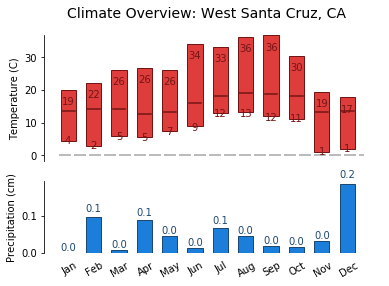

In [145]:
graph_climate(data)